#### 패키지 Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

#### 변수 설정

In [2]:
trainGraphTitle = "Train Data"
testGraphTitle = "Test Data"
checkpointPath = "./weightCheckpoint/bestParam.hdf5"
loss = "mse" 

title = "ETC"
detail = "Test"
resultComment = f"{title} - {detail}"
fileSavePath = f"./result/{title}/{detail}"

depth = "SingleGRU" # Default
# depth = "DoubleGRU" 
# depth = "TripleGRU"

# 변수 "" 가 Default
hiddenState = 32 # units: 16 "32" 64
timeStep = 20 # input_length 10 "20" 40
activation = "tanh" # "tanh" sigmoid
epochs = 100 # 50 "100" 200
batchSize = 64 # 32 "64" 256
dataSize = 10 # 5 "10" 40
optimizer = "adam" # "adam" sgd
patience = 30 # 10 "30" 50

#### Pandas Setting

In [3]:
pd.set_option('display.max_rows', None) # row 생략 없이 출력
pd.set_option('display.max_columns', None) # col 생략 없이 출력

#### Data Load

In [4]:
apple = pd.read_csv("Apple_5Y.csv")

if dataSize == 10:
    apple = pd.read_csv("Apple_10Y.csv")
elif dataSize == 40:
    apple = pd.read_csv("Apple_Whole_Period.csv")

#### Describe 확인

In [5]:
apple.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2518.000000,2518.000000,2518.000000,2518.000000,2518.000000,2.518000e+03
mean,62.383387,63.087693,61.696664,62.416599,60.637030,1.713540e+08
std,48.683035,49.322128,48.051043,48.709794,49.248659,1.250498e+08
min,13.856071,14.271429,13.753571,13.947500,12.064585,3.519590e+07
25%,26.971249,27.219376,26.705000,26.983750,24.676634,9.188698e+07
50%,41.353750,41.872500,40.888750,41.313750,39.511671,1.301368e+08
75%,91.272499,92.881876,90.824377,91.526875,90.122925,2.045116e+08
max,182.630005,182.940002,179.119995,182.009995,180.959732,1.460852e+09


#### trainData, testData 가공

In [6]:
def transformData(data: [[float]]):
    # 날짜 제외
    data = data.drop(columns=["Date"])

    # 데이터 분리 test: 200개와 나머지
    trainSet = data[ : -200]
    testSet = data[-200 : ]
    
    # 데이터 0~1로 정규화
    sc = MinMaxScaler(feature_range=(0, 1)) 
    sc.fit(trainSet)
    trainSet = sc.transform(trainSet)
    testSet = sc.transform(testSet)
    
    # trainX, trainY, testX, testY 분리
    def parsingData(dataSet: [[float]]) -> ([[[float]]], [[float]]):
        dataX, dataY = [], []
        for index in range(len(dataSet) - timeStep):
            temp = []
            for step in range(timeStep):
                temp.append(dataSet[index + step])
            dataX.append(temp)
            dataY.append(dataSet[index + timeStep])

        return np.array(dataX), np.array(dataY)

    trainDataX, trainDataY = parsingData(trainSet)
    testDataX, testDataY = parsingData(testSet)
    
    
    return trainDataX, trainDataY, testDataX[:-30], testDataY, sc

#### Data Parsing

In [7]:
trainX, trainY, testX, testY, scaler = transformData(apple)

#### Model Implementation

In [8]:
model = Sequential()

if depth == "SingleGRU":
    model.add(
    GRU(
        units = hiddenState,
        input_length = trainX.shape[1],
        input_dim = trainX.shape[2],
        activation = activation
        )
    )
    model.add(Dense(6))
    
    
    
    
elif depth == "DoubleGRU":
    model.add(
        GRU(
            units = hiddenState,
            input_length = trainX.shape[1],
            input_dim = trainX.shape[2],
            activation = activation,
            return_sequences = True
        )
    )
    model.add(
        GRU(
            units = hiddenState,
            activation = activation
        )
    )
    
    model.add(Dense(6))
    
elif depth == "TripleGRU":
    model.add(
        GRU(
            units = hiddenState,
            input_length = trainX.shape[1],
            input_dim = trainX.shape[2],
            activation = activation,
            return_sequences = True
        )
    )
    model.add(
        GRU(
            units = hiddenState,
            activation = activation,
            return_sequences = True
        )
    )
    model.add(
        GRU(
            units = hiddenState,
            activation = activation
        )
    )
    
    model.add(Dense(6))

model.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3840      
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
Total params: 4,038
Trainable params: 4,038
Non-trainable params: 0
_________________________________________________________________


2023-01-05 15:20:43.573214: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-05 15:20:43.573298: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Model Complie

In [9]:
model.compile(
    loss = loss,
    optimizer = optimizer,
    metrics = ["mae"]
)

#### Model Training

In [10]:
earlyStop = EarlyStopping(
    monitor = 'loss',
    min_delta = 0.0001,
    patience = patience,
    verbose = 1
)
saveBest = ModelCheckpoint(
    filepath = checkpointPath,
    monitor = "loss",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = "auto",
    save_freq = "epoch"
)

fitStartTime = time.time()
history = model.fit(
    trainX,
    trainY,
    epochs = epochs,
    batch_size = batchSize,
    callbacks = [earlyStop, saveBest]
)
fitEndTime = time.time()


model.load_weights(checkpointPath)

Epoch 1/100


2023-01-05 15:20:43.794012: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 15:20:44.462200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-05 15:20:44.558425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 5/36 [===>..........................] - ETA: 0s - loss: 0.1261 - mae: 0.2308 

2023-01-05 15:20:44.683894: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - ETA: 0s - loss: 0.0492 - mae: 0.1373
Epoch 1: loss improved from inf to 0.04920, saving model to ./weightCheckpoint/bestParam.hdf5
36/36 [==============================] - 2s 16ms/step - loss: 0.0492 - mae: 0.1373
Epoch 2/100
35/36 [============================>.] - ETA: 0s - loss: 0.0043 - mae: 0.0489
Epoch 2: loss improved from 0.04920 to 0.00419, saving model to ./weightCheckpoint/bestParam.hdf5
36/36 [==============================] - 0s 12ms/step - loss: 0.0042 - mae: 0.0482
Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: 9.2365e-04 - mae: 0.0197
Epoch 3: loss improved from 0.00419 to 0.00092, saving model to ./weightCheckpoint/bestParam.hdf5
36/36 [==============================] - 0s 11ms/step - loss: 9.2365e-04 - mae: 0.0197
Epoch 4/100
36/36 [==============================] - ETA: 0s - loss: 7.7837e-04 - mae: 0.0162
Epoch 4: loss improved from 0.00092 to 0.00078, saving model to ./weightCheckpoint/bestParam.hdf5
36/

35/36 [============================>.] - ETA: 0s - loss: 5.0411e-04 - mae: 0.0109
Epoch 31: loss did not improve from 0.00050
36/36 [==============================] - 1s 14ms/step - loss: 5.0153e-04 - mae: 0.0109
Epoch 32/100
32/36 [=========================>....] - ETA: 0s - loss: 5.0703e-04 - mae: 0.0110
Epoch 32: loss did not improve from 0.00050
36/36 [==============================] - 0s 13ms/step - loss: 5.0492e-04 - mae: 0.0110
Epoch 33/100
35/36 [============================>.] - ETA: 0s - loss: 4.8469e-04 - mae: 0.0105
Epoch 33: loss improved from 0.00050 to 0.00049, saving model to ./weightCheckpoint/bestParam.hdf5
36/36 [==============================] - 0s 13ms/step - loss: 4.9049e-04 - mae: 0.0105
Epoch 34/100
35/36 [============================>.] - ETA: 0s - loss: 4.8039e-04 - mae: 0.0105
Epoch 34: loss improved from 0.00049 to 0.00049, saving model to ./weightCheckpoint/bestParam.hdf5
36/36 [==============================] - 0s 11ms/step - loss: 4.8960e-04 - mae: 0.0105

#### 이후 30일 예측

In [11]:
thirtyPredict = testX

for _ in range(30):
    currentPredict = model.predict(thirtyPredict)
    recentPredict = np.reshape(currentPredict[-1], (1, currentPredict[-1].shape[0]))
    newPredictStep = thirtyPredict[-1, 1:]
    nextPredict = np.append(newPredictStep, recentPredict, axis = 0)
    nextPredict = np.reshape(nextPredict, (1, nextPredict.shape[0], nextPredict.shape[1]))
    thirtyPredict = np.append(thirtyPredict, nextPredict, axis = 0)

1/5 [=====>........................] - ETA: 0s

2023-01-05 15:21:03.442786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-05 15:21:03.472971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 14ms/step


#### 결과 기록

In [12]:
fitTime = fitEndTime - fitStartTime
score = model.evaluate(testX, testY[:-30])
predictScore = model.evaluate(thirtyPredict[-30:], testY[-30:])
parameters = f"""
layer = {depth}
hiddenState = {hiddenState}
timeStep = {timeStep}
activation = {activation}
epochs = {epochs}
batchSize = {batchSize}
dataSetYear = {dataSize}
optimizer = {optimizer}
patience = {patience}
"""

f = open("result.txt", "a")
f.write(f"{resultComment}\n모델 학습 시간: {fitTime:.3} sec\n평가 손실: {score[0]}\n30일 예측 손실: {predictScore[0]}\n{parameters}\n--------------------------------------\n\n")
f.close()

5/5 [==============================] - 0s 16ms/step - loss: 7.2591e-04 - mae: 0.0213


2023-01-05 15:21:06.297189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-05 15:21:06.331402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 56ms/step - loss: 0.0047 - mae: 0.0511


In [13]:
print(f"모델 학습 시간: {fitTime:.3} sec")

모델 학습 시간: 19.5 sec


In [14]:
print(f"평가 손실: {score[0]}")

평가 손실: 0.0007259132689796388


In [15]:
print(f"30일 예측 손실: {predictScore[0]}")

30일 예측 손실: 0.0047469111159443855


#### Test Data 예측 및 역정규화

In [16]:
trainPrediction = scaler.inverse_transform(model.predict(trainX))
testPrediction = scaler.inverse_transform(model.predict(testX))

inversingTrainY = scaler.inverse_transform(trainY)
inversingTestY = scaler.inverse_transform(testY)

5/5 [==============================] - 0s 7ms/step


### 그래프

#### Loss

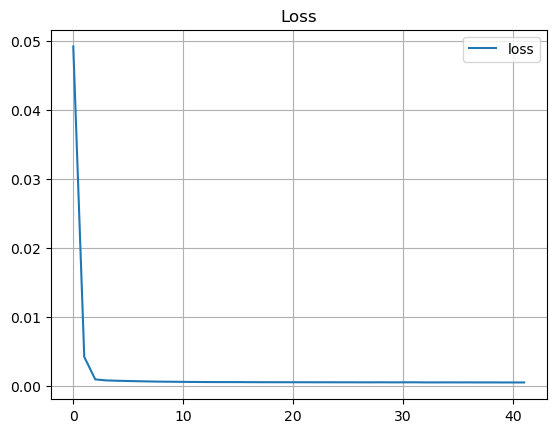

In [17]:
loss = history.history["loss"]
plt.title("Loss")
plt.plot(loss, label="loss")
plt.grid(True)
plt.savefig(f"{fileSavePath}/Loss.png")
plt.legend()
plt.show()

#### Train Data Graph

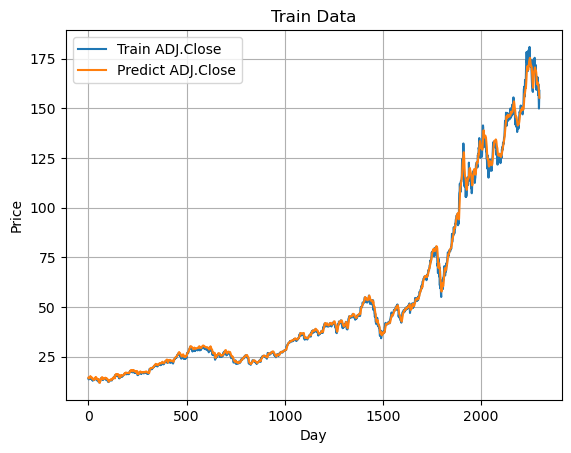

In [18]:
plt.title(trainGraphTitle)
plt.plot(inversingTrainY[:, 4], label="Train ADJ.Close")
plt.plot(trainPrediction[:, 4], label="Predict ADJ.Close")
plt.grid(True)
plt.savefig(f"{fileSavePath}/Train.png")
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()

#### Test Data Graph

In [19]:
# plt.title(testGraphTitle)
# plt.plot(inversingTestY[:, 4], label="Test ADJ.Close")
# plt.plot(testPrediction[:, 4], label="Predict ADJ.Close")
# plt.grid(True)
# plt.xlabel('Day')
# plt.ylabel('Price')
# plt.axvline(x=len(testY)-30, color='green', linestyle='-', linewidth=1)
# plt.legend()
# plt.savefig(f"{fileSavePath}/Test.png")
# plt.show()

#### Test Data + 30일 예측 그래프

6/6 [==============================] - 0s 13ms/step


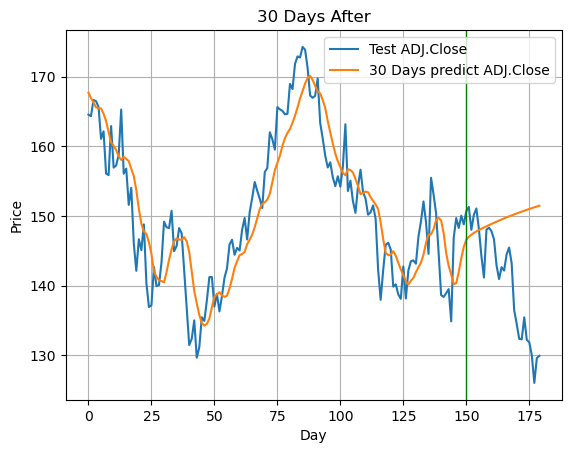

In [20]:
thirtyDaysAfterpredict = scaler.inverse_transform(model.predict(thirtyPredict))

plt.title("30 Days After")
plt.plot(inversingTestY[:, 4], label="Test ADJ.Close")
plt.plot(thirtyDaysAfterpredict[:, 4], label="30 Days predict ADJ.Close")
plt.grid(True)
plt.xlabel('Day')
plt.ylabel('Price')
plt.axvline(x=len(testY)-30, color='green', linestyle='-', linewidth=1)
plt.legend()
plt.savefig(f"{fileSavePath}/30Predict.png")
plt.show()